## Attention Only Classification Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models import *
from utility_functions import *

sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Set Model Settings

In [91]:
### settings for attention model ###
attention_num_motifs=150
attention_motif_size=10
adjacent_bp_pool_size=10
attention_dropout_rate=0.1

### settings for convolution model ###
convolution_num_motifs=16
convolution_motif_size=24
num_dense_neurons=32
convolution_dropout_rate=0.5

largeConvolution_num_motifs = 100
large_num_dense_neurons = 32

In [92]:
large_convolution_model = get_convolution_model(200,
        mode='classification',
        num_motifs=largeConvolution_num_motifs, 
        motif_size=convolution_motif_size,
        num_dense_neurons=large_num_dense_neurons,
        dropout_rate=convolution_dropout_rate,
        num_classes=2)
large_convolution_model.count_params()

12998

## Train All Models for all Data Sets

In [93]:
num_epochs = 30
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
train_addAttention = False
train_dotAttention = True
train_convolution = True
train_large_convolution = True

# condition_model_dict = {}
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
       
    ### additive attention model ###
#     print('Training AddAttention', treatment)
#     additiveAttention_model = get_additiveAttention_model(200,
#         mode='classification',
#         num_motifs=150, 
#         motif_size=10,
#         adjacent_bp_pool_size=10,
#         attention_dim=10,
#         attention_hops=10,
#         dropout_rate=0.1
#     )
        
#     additiveAttention_model.fit([x_train], y_train,
#               batch_size=64,
#               epochs=num_epochs,
#               verbose=1,
#               validation_data=([x_test], y_test))

#     probs = additiveAttention_model.predict([x_test])
#     test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
#     roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
#     precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
#     acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
#     param_count = additiveAttention_model.count_params()
# 
#     all_rocs.append(roc)
#     all_accuracies.append(acc)
#     all_precisions.append(precision)
#     all_treatments.append(treatment)
#     model_types.append('AddAttention')
#     parameter_counts.append(param_count)
#     condition_model_dict['AddAttention_'+treatment] = additiveAttention_model
    ### ###
    
    ### dot product attention model ###
    if train_dotAttention:
        print('Training DotAttention', treatment)
        dotProductAttention_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            dropout_rate=attention_dropout_rate,
            num_classes=2)

        dotProductAttention_model.fit([x_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test], y_test))

        probs = dotProductAttention_model.predict([x_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = dotProductAttention_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('DotAttention')
        parameter_counts.append(param_count)
        condition_model_dict['DotAttention_'+treatment] = dotProductAttention_model
    ### ###

    ### convolution model ###
    if train_convolution:
        print('Training Convolution', treatment)
        convolution_model = get_convolution_model(200,
            mode='classification',
            num_motifs=convolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
        convolution_model.fit([x_train, x_rc_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test, x_rc_test], y_test))

        probs = convolution_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = convolution_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('Convolution')
        parameter_counts.append(param_count)
        condition_model_dict['Convolution_'+treatment] = convolution_model
    
    ### large convolution model ###
    if train_large_convolution:
        print('Training Large Convolution', treatment)
        large_convolution_model = get_convolution_model(200,
            mode='classification',
            num_motifs=largeConvolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=large_num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
        large_convolution_model.fit([x_train, x_rc_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test, x_rc_test], y_test))

        probs = large_convolution_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = convolution_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('LargeConvolution')
        parameter_counts.append(param_count)
        condition_model_dict['LargeConvolution_'+treatment] = large_convolution_model

*** kla-1h ***
Training Convolution kla-1h
Train on 34841 samples, validate on 8711 samples
Epoch 1/30
34841/34841 [==============================] - 9s 265us/step - loss: 0.6818 - categorical_accuracy: 0.5525 - val_loss: 0.6260 - val_categorical_accuracy: 0.6873
Epoch 2/30
34841/34841 [==============================] - 7s 210us/step - loss: 0.5632 - categorical_accuracy: 0.7171 - val_loss: 0.5133 - val_categorical_accuracy: 0.7460
Epoch 3/30
34841/34841 [==============================] - 7s 209us/step - loss: 0.5079 - categorical_accuracy: 0.7583 - val_loss: 0.4809 - val_categorical_accuracy: 0.7675
Epoch 4/30
34841/34841 [==============================] - 7s 209us/step - loss: 0.4767 - categorical_accuracy: 0.7807 - val_loss: 0.4607 - val_categorical_accuracy: 0.7794
Epoch 5/30
34841/34841 [==============================] - 7s 209us/step - loss: 0.4530 - categorical_accuracy: 0.7953 - val_loss: 0.4437 - val_categorical_accuracy: 0.7913
Epoch 6/30
34841/34841 [========================

34841/34841 [==============================] - 9s 250us/step - loss: 0.2398 - categorical_accuracy: 0.8939 - val_loss: 0.4023 - val_categorical_accuracy: 0.8342
Epoch 18/30
34841/34841 [==============================] - 9s 251us/step - loss: 0.2386 - categorical_accuracy: 0.8924 - val_loss: 0.4365 - val_categorical_accuracy: 0.8206
Epoch 19/30
34841/34841 [==============================] - 9s 248us/step - loss: 0.2351 - categorical_accuracy: 0.8953 - val_loss: 0.4525 - val_categorical_accuracy: 0.8348
Epoch 20/30
34841/34841 [==============================] - 9s 249us/step - loss: 0.2293 - categorical_accuracy: 0.8973 - val_loss: 0.4384 - val_categorical_accuracy: 0.8347
Epoch 21/30
34841/34841 [==============================] - 9s 250us/step - loss: 0.2213 - categorical_accuracy: 0.9008 - val_loss: 0.4405 - val_categorical_accuracy: 0.8308
Epoch 22/30
34841/34841 [==============================] - 9s 254us/step - loss: 0.2147 - categorical_accuracy: 0.9029 - val_loss: 0.5143 - val_cat

50480/50480 [==============================] - 12s 247us/step - loss: 0.4137 - categorical_accuracy: 0.8204 - val_loss: 0.3804 - val_categorical_accuracy: 0.8274
Epoch 4/30
50480/50480 [==============================] - 13s 250us/step - loss: 0.3828 - categorical_accuracy: 0.8363 - val_loss: 0.3727 - val_categorical_accuracy: 0.8326
Epoch 5/30
50480/50480 [==============================] - 13s 251us/step - loss: 0.3593 - categorical_accuracy: 0.8468 - val_loss: 0.3690 - val_categorical_accuracy: 0.8350
Epoch 6/30
50480/50480 [==============================] - 13s 252us/step - loss: 0.3445 - categorical_accuracy: 0.8562 - val_loss: 0.3727 - val_categorical_accuracy: 0.8384
Epoch 7/30
50480/50480 [==============================] - 13s 248us/step - loss: 0.3282 - categorical_accuracy: 0.8632 - val_loss: 0.3648 - val_categorical_accuracy: 0.8374
Epoch 8/30
50480/50480 [==============================] - 13s 248us/step - loss: 0.3178 - categorical_accuracy: 0.8687 - val_loss: 0.3841 - val_ca

Epoch 20/30
53628/53628 [==============================] - 11s 211us/step - loss: 0.3774 - categorical_accuracy: 0.8350 - val_loss: 0.3823 - val_categorical_accuracy: 0.8275
Epoch 21/30
53628/53628 [==============================] - 11s 211us/step - loss: 0.3738 - categorical_accuracy: 0.8377 - val_loss: 0.3848 - val_categorical_accuracy: 0.8259
Epoch 22/30
53628/53628 [==============================] - 11s 211us/step - loss: 0.3735 - categorical_accuracy: 0.8363 - val_loss: 0.3822 - val_categorical_accuracy: 0.8282
Epoch 23/30
53628/53628 [==============================] - 11s 210us/step - loss: 0.3732 - categorical_accuracy: 0.8370 - val_loss: 0.3806 - val_categorical_accuracy: 0.8301
Epoch 24/30
53628/53628 [==============================] - 11s 211us/step - loss: 0.3722 - categorical_accuracy: 0.8377 - val_loss: 0.3799 - val_categorical_accuracy: 0.8291
Epoch 25/30
53628/53628 [==============================] - 11s 211us/step - loss: 0.3703 - categorical_accuracy: 0.8385 - val_loss

## Serialize Models

In [94]:
if len(condition_model_dict) > 0:
    if not os.path.isdir(working_directory + '/models_classification'):
        os.mkdir(working_directory + '/models_classification')
    else:
        for f in os.listdir(working_directory + '/models_classification'):
            os.remove(working_directory + '/models_classification/' + f)
    for treatment_modelType in condition_model_dict.keys():
        current_model = condition_model_dict[treatment_modelType]
        current_model.save_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                          )

## Read in Models

In [80]:
condition_model_dict = {}
for f in os.listdir(working_directory + '/models_classification/'):
    treatment_modelType = f.replace('_weights.h5','')
    modelType = treatment_modelType.split('_')[0]    
    if modelType == 'DotAttention':
        current_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            dropout_rate=attention_dropout_rate,
            num_classes=2)  
    elif modelType == 'Convolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs=convolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    elif modelType == 'LargeConvolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs= largeConvolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=large_num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    current_model.load_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                              )
    condition_model_dict[treatment_modelType] = current_model

## Test Model Performance

In [95]:
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    for treatment_model in condition_model_dict.keys():      
        if treatment_model.split('_')[1] == treatment:
            current_model = condition_model_dict[treatment_model] 
            if treatment_model.split('_')[0] == 'Convolution':
                probs = current_model.predict([x_test, x_rc_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = convolution_model.count_params()
                model_types.append('Convolution')
            elif treatment_model.split('_')[0] == 'LargeConvolution':
                probs = current_model.predict([x_test, x_rc_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = convolution_model.count_params()
                model_types.append('LargeConvolution')
            elif treatment_model.split('_')[0] == 'DotAttention':
                probs = current_model.predict([x_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = current_model.count_params()
                model_types.append('DotAttention')
            else:
                print('moo', treatment_model)
            
            
            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            
            parameter_counts.append(param_count)
            print(treatment_model, acc, roc, precision)

*** kla-1h ***
Convolution_kla-1h 0.8598323958213753 0.9287874232131801 0.8394366197183099
DotAttention_kla-1h 0.9073585122259212 0.9589725887380842 0.890380805635043
LargeConvolution_kla-1h 0.908850878199977 0.9753556834766286 0.8575733226195259
*** veh ***
DotAttention_veh 0.8991283676703645 0.936092542258519 0.8883116883116883
LargeConvolution_veh 0.8972266244057052 0.9689080600424212 0.8508808433902066
Convolution_veh 0.8446909667194928 0.9199942537777682 0.8186430849521601
*** il4-24h ***
DotAttention_il4-24h 0.8960322195704057 0.94802465290424 0.8906389301634473
Convolution_il4-24h 0.8522523866348448 0.9264891086322413 0.819450143619204
LargeConvolution_il4-24h 0.9166915274463007 0.9717985028875247 0.9143584368917502


In [96]:
performance_frame = pd.DataFrame({'Model Type': model_types, 
                                  'Treatment':all_treatments,
                                  'Accuracy':all_accuracies, 
                                  'aucROC':all_rocs,
                                  'Precision':all_precisions})

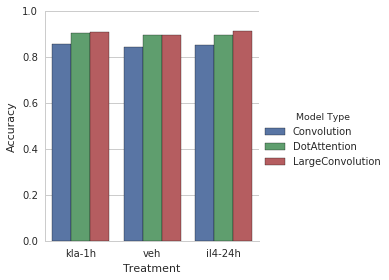

In [97]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Accuracy',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

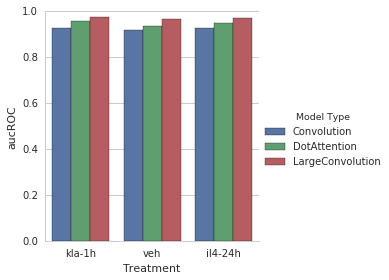

In [98]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'aucROC',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

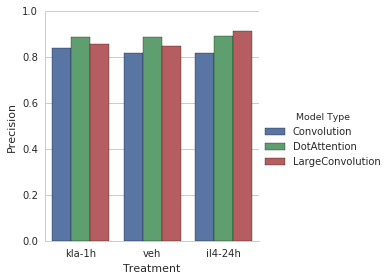

In [99]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Precision',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

## Grid Search for Dot Product Attention Model

In [ ]:
all_rocs = []
all_accuracies = []
all_precisions = []
poolSize_list = []
all_treatments = []
motifCount_list = []
numDense_list = []
paramCount_list = []
dropoutRate_list = []
num_epochs = 20
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    treatment = ps.split('_')[1]
    
    for d in range(50,200,50):
        for m in range(50,200,50):
            for p in [5,10,20]:
                for do in [0.25,0.5,0.75]:
                    
                    current_model = get_dotProductAttention_model(200,
                        mode='classification',
                        num_classes = 2,
                        num_motifs=m, 
                        motif_size=10,
                        adjacent_bp_pool_size=p,
                        num_dense_neurons=d,
                        dropout_rate=do)
                    num_params = current_model.count_params()
                    print(treatment, 
                         'num dense', d,
                         'num motifs', m,
                         'pool size', p,
                         'dropout rate', do,
                         'param count', num_params)
                    current_model.fit(x_train, y_train,
                          batch_size=64,
                          epochs=num_epochs,
                          verbose=1,
                          validation_data=([x_test], y_test))

                    probs = current_model.predict([x_test])
                    test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1])
                    precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
                    acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                    
                    all_rocs.append(roc)
                    all_accuracies.append(acc)
                    all_precisions.append(precision)
                    poolSize_list.append(p)
                    all_treatments.append(treatment)
                    motifCount_list.append(m)
                    numDense_list.append(d)
                    paramCount_list.append(num_params)
                    dropoutRate_list.append(do)

In [21]:
performance_frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'Pool Size':poolSize_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments,
                      'Num Motifs':motifCount_list,
                      'Num Dense':numDense_list,
                      'Num Params':paramCount_list,
                      'Dropout Rate':dropoutRate_list
                      })

In [22]:
performance_frame.to_csv('./grid_search_results.tsv', sep='\t')

In [29]:
performance_frame[performance_frame['Treatment'] == 'kla-1h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
50,0.835725,0.75,100,150,40152,10,0.870618,kla-1h,0.920197
77,0.837447,0.75,150,150,56702,10,0.873728,kla-1h,0.916011
23,0.837791,0.75,50,150,23602,10,0.879173,kla-1h,0.915555
68,0.839972,0.75,150,100,39352,10,0.896112,kla-1h,0.915317
11,0.831133,0.75,50,100,17752,5,0.866940,kla-1h,0.914013


In [30]:
performance_frame[performance_frame['Treatment'] == 'il4-24h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
185,0.853222,0.75,50,150,23602,10,0.885384,il4-24h,0.930444
209,0.848150,0.75,100,150,43152,5,0.851699,il4-24h,0.927972
200,0.842035,0.75,100,100,30802,5,0.912084,il4-24h,0.927763
212,0.829430,0.75,100,150,40152,10,0.818121,il4-24h,0.927611
239,0.847554,0.75,150,150,56702,10,0.849713,il4-24h,0.927164


In [31]:
performance_frame[performance_frame['Treatment'] == 'veh'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
104,0.854675,0.75,50,150,23602,10,0.885764,veh,0.928435
158,0.853645,0.75,150,150,56702,10,0.880882,veh,0.926461
157,0.843978,0.50,150,150,56702,10,0.887498,veh,0.924575
155,0.848653,0.75,150,150,61202,5,0.884820,veh,0.923599
149,0.850634,0.75,150,100,39352,10,0.846551,veh,0.923239


(0.8, 0.9)

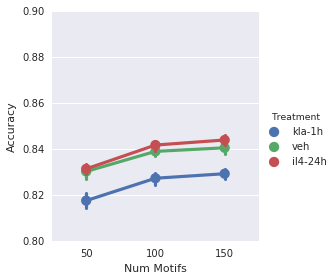

In [64]:
sns.factorplot(data = performance_frame, x = 'Num Motifs', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

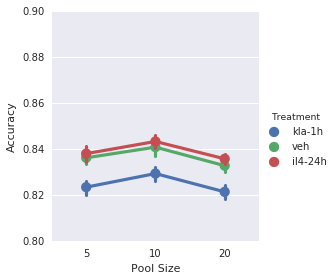

In [63]:
sns.factorplot(data = performance_frame, x = 'Pool Size', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

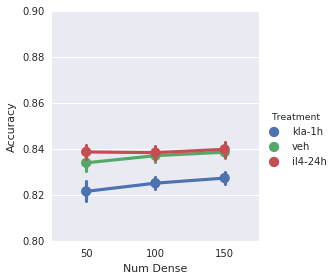

In [62]:
sns.factorplot(data = performance_frame, x = 'Num Dense', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

## Weight Extraction

In [128]:
def get_sequence_attention(model, sequences, sequence_size, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attention_softmax_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequences]
    
    trimmed_sequence_arrays = convert_sequences_to_array(trimmed_sequences)

    layer_output = get_attention((trimmed_sequence_arrays, 0))[0]
    reshaped_output = layer_output.reshape((layer_output.shape[1], layer_output.shape[2]))

    return layer_output, trimmed_sequences

In [ ]:
layer_output, full_attention, attended_sequence = get_sequence_attention(dotProductAttention_model,
                                                                         str(positive_seqRecords[100].seq),
                                                                         10)

In [53]:
full_attention.shape

(150, 15)

In [54]:
attended_sequence

'AGACGCCTCCTAGGGCCGAAACCTCACCTCCCTTTGCCCGCCTGTTCCCTATGCATCTTGGAAATCGTAGTCCTCTGTAAACCAGCTGCTGAGGCGAGCGCCTCTAGTGTACTACAAGTCCCAGGATTCCATGCATCCGCAGGGCCTTAG'

In [55]:
chunks = []
for i in range(0,len(attended_sequence),10):
#     print(i, i+5, attended_sequence[i:i+5])
    chunks.append(attended_sequence[i:i+10])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text yticklabel objects>)

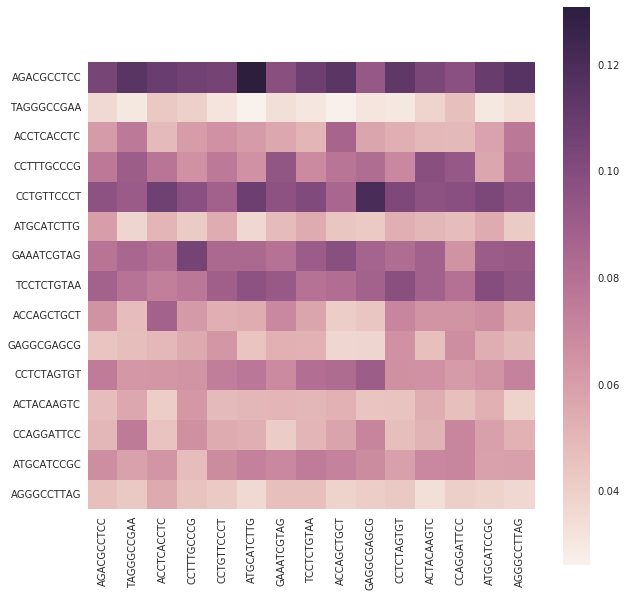

In [56]:
plt.figure(figsize = (10,10))
sns.heatmap(layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]), 
    square = True,
    yticklabels = chunks,
    xticklabels=chunks)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

In [39]:
summed_attention = layer_output.reshape(layer_output.shape[1], 
                                 layer_output.shape[2]).sum(axis=1)

In [40]:
summed_attention = summed_attention.reshape((len(summed_attention),1))

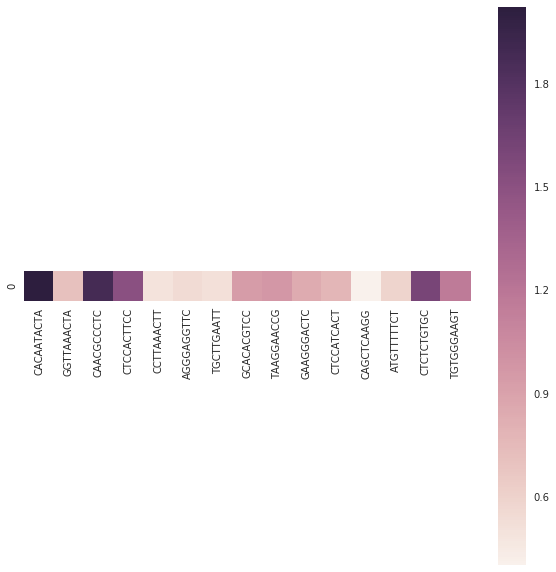

In [41]:
plt.figure(figsize = (10,10))


sns.heatmap(summed_attention.T,
            square = True,
            xticklabels=chunks)